In [30]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import time
import random
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.models import resnet152
from torchvision.transforms import v2
from torch.utils.data import DataLoader


# seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [31]:
# model
model = resnet152(pretrained=True)
model = nn.DataParallel(model)
model.to(device)

# data
img_paths = glob.glob("./data/Zeiler-Fergus/*")
labels = [366, 355, 312, 261, 298]

In [32]:
'''
課題5
Grad CAM
'''

img_idx = 4
o_img = read_image(img_paths[img_idx])
label = labels[img_idx]

In [33]:
class GradCam:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradients = None

        # フォワードフック：特徴マップを保存
        target_layer.register_forward_hook(
            lambda m,inp,out: setattr(self, 'feature_maps', out.detach())
        )

        # バックワードフック: 勾配を保存
        target_layer.register_full_backward_hook(
            lambda m,grad_in,grad_out: setattr(self, 'gradients', grad_out[0].detach()) # Tupple(dL/dy,)より
        )
    
    def __call__(self, input_tensor, class_idx):
        # 順伝播
        logits = self.model(input_tensor)
        score = logits[0, class_idx]

        # 逆伝播
        self.model.zero_grad()
        score.backward(retain_graph=False)

        # 重み係数
        grads = self.gradients[0] # [K,h,w]
        alpha = grads.mean(dim=(1,2)) # [K]

        maps = self.feature_maps[0] # [K,h,w]
        cam = F.relu((alpha.view(-1,1,1) * maps).sum(dim=0))
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        # リサイズ
        cam_tensor = cam.unsqueeze(0).unsqueeze(0)        # [1,1,h,w]
        cam_resized = F.interpolate(
            cam_tensor, size=input_tensor.shape[2:],       # 高さ・幅を元入力と同じに
            mode='bilinear', align_corners=False
        )[0,0]           
                                        # [H, W]
        return cam_resized.cpu().numpy()

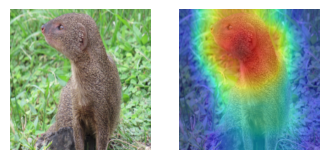

In [34]:
# exp
transform_1 = v2.Compose([
    v2.Resize([256, 256]),
    v2.ToDtype(torch.float, scale=True),
])
transform_2 = v2.Compose([
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_1 = transform_1(o_img)
img_2 = transform_2(img_1).unsqueeze(0)
img_2.to(device)

target_layer = model.module.layer4[-1].conv3
gradcam = GradCam(model, target_layer)
cam_map = gradcam(img_2, label)

# 可視化
plt.figure(figsize=(4,4))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img_1.permute(1,2,0))

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(img_1.permute(1,2,0))
plt.imshow(cam_map, cmap='jet', alpha=0.5, vmin=0, vmax=1)